<a href="https://colab.research.google.com/github/malix986/progettone-ml/blob/main/Master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Librerie**

In [ ]:
#Installo dipendenze
!pip install ultralytics==8.0.122


#modifica di baldo NUOVA

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.0/612.0 kB 12.9 MB/s eta 0:00:00


In [ ]:
#CARICO LIBRERIE e io intanto modifico qui per vedere se funziona iji

from google.colab import drive
import cv2 # Per gestire immagini
from google.colab.patches import cv2_imshow # Versione compatibile con colab per visualizzare
import gdown #scaricare file

from ultralytics import YOLO # ML identificazione palla
import pickle
import pandas as pd # lavorare con i dataframe



In [ ]:
# prompt: import a function that is defined inside another ipynb file

from google.colab import drive
drive.mount('/content/drive')
# %cd "drive/My Drive/Colab Notebooks/"
!cp drive/My\ Drive/Colab\ Notebooks/my_lib.ipynb ./
# %run my_lib.ipynb
import import_ipynb
import my_lib
my_lib.my_funct()


KeyboardInterrupt: 

# **Scarico e definisco percorso dei file**

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Scarico file**
(da fare solo la prima volta per installarli su drive)

In [ ]:
####VIDEO
#video_url = 'https://drive.google.com/uc?export=download&id=1amP0qhTjo_RxcgQePFXZHIVeiy-mu9Dd'
#output_path = '/content/drive/My Drive/shared_colab_folder/video_scaricato.mp4'
#gdown.download(url=video_url, output=output_path, quiet=False)

#aggiungere scaricone dei modelli

Downloading...
From: https://drive.google.com/uc?export=download&id=1amP0qhTjo_RxcgQePFXZHIVeiy-mu9Dd
To: /content/drive/My Drive/shared_colab_folder/video_scaricato.mp4
100%|██████████| 12.9M/12.9M [00:01<00:00, 6.87MB/s]


### **Definisco percorso files**

In [ ]:
#VIDEO
input_video_path = '/content/drive/MyDrive/shared_colab_folder/video_scaricato.mp4' #video da analizzare
output_video_path = '/content/drive/MyDrive/shared_colab_folder/video_elaborato.avi' #destinazione video finale

#MODELLI
ball_model_path = '/content/drive/MyDrive/shared_colab_folder/models/yolo5_last.pt' #modello trainato per palla
keypoints_model_path = '/content/drive/MyDrive/shared_colab_folder/models/yolo5_last.pt' #modello trainato per angoli campo

#STUBS
ball_stub_path = '/content/drive/MyDrive/shared_colab_folder/tracker_stubs/ball_stub.pkl'

# **CLASSI**

In [ ]:
class BallTracker:
    def __init__(self,model_path):
        self.model = YOLO(model_path)

    #interpolazione palla
    def interpolate_ball_positions(self, ball_positions):

        ball_positions = [x.get(1,[]) for x in ball_positions] #lista delle posizioni della palla, vuota se non viene identificata
        # convert the list into padas dataframe
        df_ball_positions = pd.DataFrame(ball_positions,columns=['x1','y1','x2','y2'])

        # interpolate missing values
        df_ball_positions = df_ball_positions.interpolate()
        # Non interpola posizione all'inizio, quindi bisogna assicurarsi che il primo slot sia backfillato
        df_ball_positions = df_ball_positions.bfill()
        # restituisci nello stesso formato iniziale
        ball_positions = [{1:x} for x in df_ball_positions.to_numpy().tolist()]

        return ball_positions

    # stub to handle video già caricati per velocizzare
    def detect_frames(self,frames, read_from_stub=False, stub_path=None):
        ball_detections = []

        #se read è True allora apri gli stub prima della player detection
        if read_from_stub and stub_path is not None:
            with open(stub_path, 'rb') as f:
                ball_detections = pickle.load(f)
            return ball_detections

        for frame in frames:
            ball_dict = self.detect_frame(frame)
            ball_detections.append(ball_dict)

        if stub_path is not None:
            with open(stub_path, 'wb') as f:
                pickle.dump(ball_detections, f)

        return ball_detections

    def detect_frame(self,frame):
        results = self.model.predict(frame, conf=0.15)[0]

        ball_dict = {}
        for box in results.boxes:
            result = box.xyxy.tolist()[0]
            ball_dict[1]=result

        return ball_dict

    def draw_bboxes(self,video_frames, ball_detections):
        output_video_frames = []

        # zip permette di iterare su due liste insieme (frame, ball_dict)
        for frame, ball_dict in zip(video_frames, ball_detections):
            output_video_frames = []
            # Disegno i box
            for track_id, bbox in ball_dict.items():
                x1, y1, x2, y2 = bbox
                cv2.putText(frame, f"Ball ID: {track_id}",(int(bbox[0]),int(bbox[1] -10)), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,255, 255),2) #scrive 10px sotto il box
                cv2.rectangle(frame, (int(x1),int(y1)),(int(x2),int(y2)), (0, 255, 255), 2) #2 riempie solo i bordi
            output_video_frames.append(frame)
        return output_video_frames



# **UTILS**

## **Video Utils**

In [ ]:
#Video Utils
def read_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()
    return frames

def save_video(output_video_frames,output_video_path):
    fourcc = cv2.VideoWriter_fourcc(*'DIVX')
    out = cv2.VideoWriter(output_video_path, fourcc, 24, (output_video_frames[0].shape[1],output_video_frames[0].shape[0]))
    for frame in output_video_frames:
        out.write(frame)
    out.release()

# **OBJ TRACKING**

In [ ]:
# Traccio Palla
def main():

  video_frames = read_video(input_video_path)
  #Definisco modello per il tracking della palla
  ball_tracker = BallTracker(model_path=ball_model_path)
  #traccio gli spostamenti
  ball_detections = ball_tracker.detect_frames(video_frames,
                                               read_from_stub=True, #per creare il file la prima volta settare su False
                                               stub_path=ball_stub_path)
  #ball_detections = ball_tracker.interpolate_ball_positions(ball_detections)

  output_video_frames = ball_tracker.draw_bboxes(video_frames, ball_detections)
  save_video(output_video_frames,output_video_path)


main()


/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py:518: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file, map_location='cpu'), file  # load


# **VARI TEST**

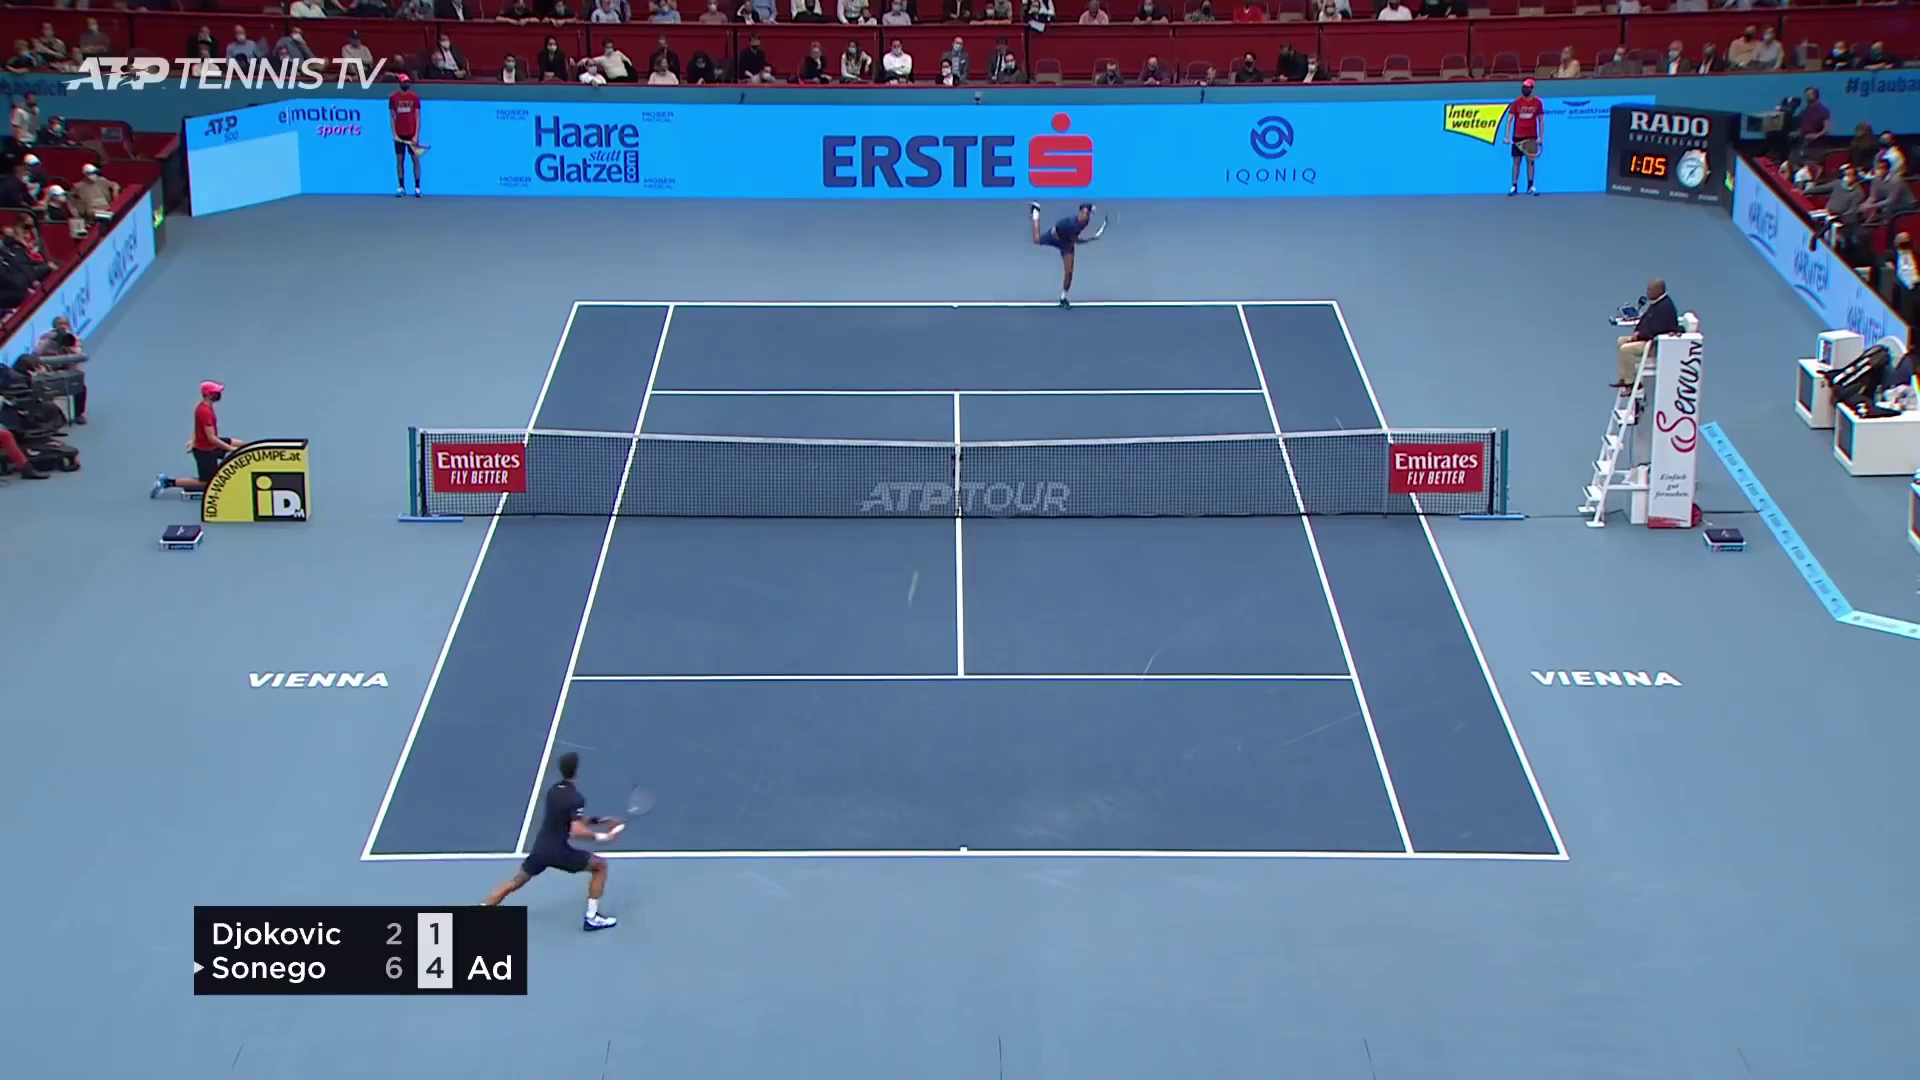

In [ ]:
# Carica il video
cap = cv2.VideoCapture(input_video_path)

# Leggi il primo frame
ret, frame = cap.read()

# Visualizza il frame
if ret:
  cv2_imshow(frame)

# Rilascia le risorse
cap.release()